# Kalman Filter Analysis

The Kalman filter is a probabilistic model of a sequence of observations z1, z2, ..., zT and a corresponding sequence of hidden states x1, x2, ..., xT

The basic idea behind the algorithm is that it uses a series of measurements observed over time, containing statistical noise and other inaccuracies, and produces estimates of unknown variables that tend to be more accurate than those based on a single measurement alone, by estimating a joint probability distribution over the variables for each timeframe.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from datetime import datetime
import itertools

import pandas as pd
from pykalman import KalmanFilter
import pywt

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [4]:
DATA_STORE = 'Data/H5/assets.h5'

#### We will run the data from NextEra Energy through this algorithim

In [5]:
with pd.HDFStore(DATA_STORE) as store:
    NEE = (store['Alt_Energy/prices']
              .loc[idx[:], 'Close',]
              .unstack('Ticker')
              .loc[idx[:], 'NEE',])

In [6]:
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

In [7]:
state_means, _ = kf.filter(NEE)

Plot the stock movement as well as the moving average for one month, two months, and three, months

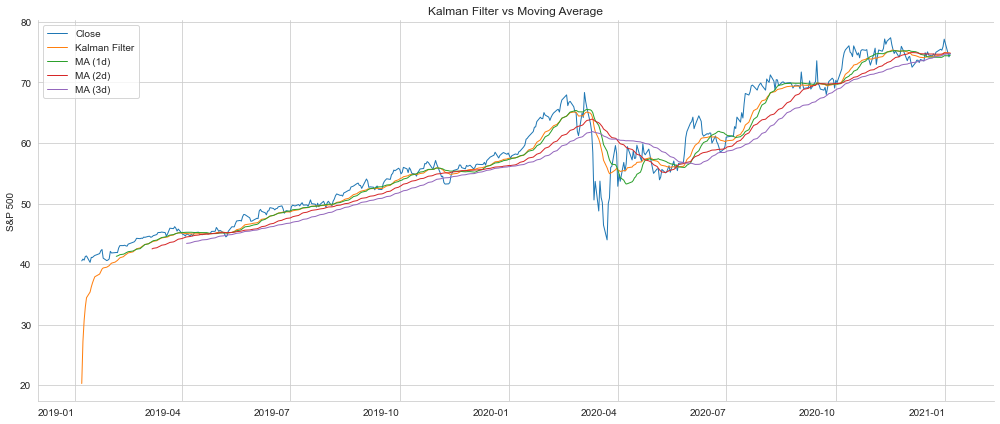

In [9]:
NEE_smoothed = NEE.to_frame('Close')
NEE_smoothed['Kalman Filter'] = state_means

for months in [1, 2, 3]:
    NEE_smoothed[f'MA ({months}m)'] = NEE.rolling(window = months * 21).mean()

ax = NEE_smoothed.plot(title = 'Kalman Filter vs Moving Average', figsize = (14, 6), lw = 1, rot = 0)
ax.set_xlabel('')
ax.set_ylabel('S&P 500')

plt.tight_layout()
sns.despine();

### Smoothing NextEra Energy Stock

We use the `pct_change` to plot our signal. This will help us seperate the noise from the actual movement of the stock. We use two thresholds - 0.1 and 0.5. The purpose of these thresholds is to omit all signals that are below a particular cutoff. The highter the threshold, the smoother the series

We will also use the `db6` wavelet. 

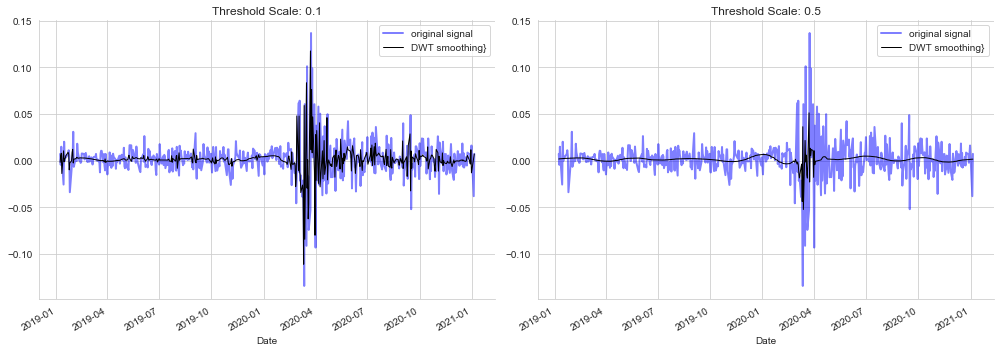

In [10]:
signal = NEE.pct_change().dropna()

fig, axes = plt.subplots(ncols = 2, figsize = (14, 5))

wavelet = "db6"
for i, scale in enumerate([.1, .5]):
    
    coefficients = pywt.wavedec(signal, wavelet, mode = 'per')
    coefficients[1:] = [pywt.threshold(i, value = scale * signal.max(), mode = 'soft') for i in coefficients[1:]]
    reconstructed_signal = pywt.waverec(coefficients, wavelet, mode = 'per')
    
    signal.plot(color = "b", alpha = 0.5, label='original signal', lw = 2, title = f'Threshold Scale: {scale:.1f}', ax = axes[i])
    
    pd.Series(reconstructed_signal[1:], index = signal.index).plot( c = 'k', label = 'DWT smoothing}', linewidth = 1, ax = axes[i])
    axes[i].legend()
    
fig.tight_layout()
sns.despine();